In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
# import cv2
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")

# Load Data

In [2]:
seed = 42

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [4]:
label_dict = {
    # Controls
    'n': 0,
    # Chirrhosis
    'cirrhosis': 1,
    # Colorectal Cancer
    'cancer': 1, 'small_adenoma': 0,
    # IBD
    'ibd_ulcerative_colitis': 1, 'ibd_crohn_disease': 1,
    # T2D and WT2D
    't2d': 1,
    # Obesity
    'leaness': 0, 'obesity': 1,
}
def loadData(data_dir, filename, dtype=None):
    feature_string = ''
    if filename.split('_')[0] == 'abundance':
        feature_string = "k__"
    if filename.split('_')[0] == 'marker':
        feature_string = "gi|"
    # read file
    filename = data_dir + filename
    if not os.path.isfile(filename):
        print("FileNotFoundError: File {} does not exist".format(filename))
        exit()
    raw = pd.read_csv(filename, sep='\t', index_col=0, header=None)

    # select rows having feature index identifier string
    X = raw.loc[raw.index.str.contains(feature_string, regex=False)].T

    # get class labels
    Y = raw.loc['disease']
    Y = Y.replace(label_dict)

    # train and test split
    X_train, X_test, y_train, y_test = train_test_split(X.values.astype(dtype), Y.values.astype('int'), test_size=0.2, random_state=seed, stratify=Y.values)
    print("Train data shape: ", X_train.shape)
    print("Test data shape: ", X_test.shape)
    return X_train, X_test, y_train, y_test

data_dir = '../data/marker/'
data_string = 'marker_Cirrhosis.txt'
X_train, X_test, y_train, y_test = loadData(data_dir, data_string, dtype='float32')

/var/folders/w2/bzjy3qrs24365t_51844lvjh0000gn/T/ipykernel_29503/2533103927.py:26: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232) have mixed types. Specify dtype option on import or set low_memory=False.

Train data shape:  (185, 120553)
Test data shape:  (47, 120553)


In [5]:
trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size=32, shuffle=False)

# Define the AE model

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=28*28):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim

        # DNN as encoder
        self.encoder1 = nn.Linear(input_dim, 128)
        self.encoder2 = nn.Linear(128, 64)
        self.encoder3 = nn.Linear(64, 32)
        self.encoder4 = nn.Linear(32, 8)

        # DNN as decoder
        self.decoder1 = nn.Linear(8, 32)
        self.decoder2 = nn.Linear(32, 64)
        self.decoder3 = nn.Linear(64, 128)
        self.decoder4 = nn.Linear(128, input_dim)

    def encoder(self, x):
        h = torch.tanh(self.encoder1(x))
        h = torch.tanh(self.encoder2(h))
        h = torch.tanh(self.encoder3(h))
        return torch.tanh(self.encoder4(h))

    def decoder(self, z):
        h = torch.tanh(self.decoder1(z))
        h = torch.tanh(self.decoder2(h))
        h = torch.tanh(self.decoder3(h))
        return torch.sigmoid(self.decoder4(h))

    def forward(self, x):
        z = self.encoder(x.view(-1, self.input_dim))
        return self.decoder(z)

    @staticmethod
    def loss_func(x_hat, x):
        return F.mse_loss(x_hat, x, reduction='sum')

In [7]:
model = AutoEncoder(input_dim=X_train.shape[1]).to(device)

# Model training and evaluation

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.002)

losses = []
for epoch in range(200):

    """ model training """
    model.train()
    cur_rec_loss = []
    for batch_idx, (data, _) in enumerate(trainloader):
        data = data.to(device)
        rec = model(data)
        loss = model.loss_func(rec, data.reshape(data.shape[0], -1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cur_rec_loss.append(loss.item())
    losses.append(np.mean(cur_rec_loss))

    """ model evaluation """
    with torch.no_grad():
        test_loss = []
        for batch_idx, (data, _) in enumerate(testloader):
            data = data.to(device)
            rec = model(data)
            loss = model.loss_func(rec, data)
            test_loss.append(loss.item())

    if epoch % 10 == 0:
        print (f"-- epoch {epoch} --, train MSE: {np.mean(cur_rec_loss)}, test MSE: {np.mean(test_loss)}")

-- epoch 0 --, train MSE: 877666.5, test MSE: 560997.0625
-- epoch 10 --, train MSE: 266054.6822916667, test MSE: 202025.5859375
-- epoch 20 --, train MSE: 264156.3333333333, test MSE: 200806.515625
-- epoch 30 --, train MSE: 263891.1640625, test MSE: 200845.57421875
-- epoch 40 --, train MSE: 263596.1848958333, test MSE: 200500.5078125
-- epoch 50 --, train MSE: 263489.6119791667, test MSE: 200435.8515625
-- epoch 60 --, train MSE: 263486.0546875, test MSE: 200532.23828125
-- epoch 70 --, train MSE: 263509.2447916667, test MSE: 200444.25
-- epoch 80 --, train MSE: 263461.9192708333, test MSE: 200577.140625
-- epoch 90 --, train MSE: 263445.34375, test MSE: 200364.15625
-- epoch 100 --, train MSE: 263387.3619791667, test MSE: 200551.30078125
-- epoch 110 --, train MSE: 263451.7109375, test MSE: 200449.953125
-- epoch 120 --, train MSE: 263414.1666666667, test MSE: 200421.12890625
-- epoch 130 --, train MSE: 263417.9453125, test MSE: 200550.84765625
-- epoch 140 --, train MSE: 263409.67

# Draw Loss and Accuracy Curves

Text(0.5, 1.0, 'rec MSE loss')

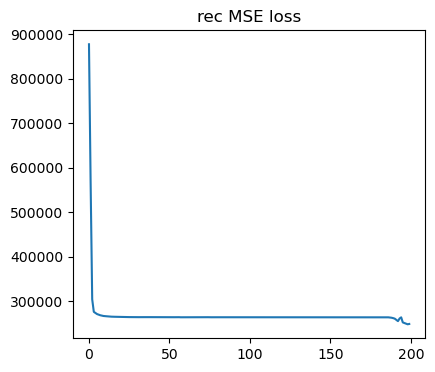

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(losses)
plt.title("rec MSE loss")

# Transform the data by using the trained model

In [10]:
X_train = torch.tensor(X_train).to(device)
X_test = torch.tensor(X_test).to(device)

X_train_encoded = model.encoder(X_train).cpu().detach().numpy()
X_test_encoded = model.encoder(X_test).cpu().detach().numpy()

# Classification by using the transformed data

In [11]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
def get_metrics(clf, is_svm=False):
    y_true, y_pred = y_test, clf.predict(X_test_encoded)
    y_prob = 0
    if is_svm:
        y_prob = clf.decision_function(X_test_encoded)
    else:
        y_prob = clf.predict_proba(X_test_encoded)
    # Performance Metrics: AUC, ACC, Recall, Precision, F1_score
    metrics = {
    'ACC': accuracy_score(y_true, y_pred),
    'Recall': recall_score(y_true, y_pred),
    'Precision': precision_score(y_true, y_pred),
    'F1_score': f1_score(y_true, y_pred),
    }
    if not is_svm:
        metrics['AUC'] = roc_auc_score(y_true, y_prob[:, 1])
    else:
        metrics['AUC'] = roc_auc_score(y_true, y_prob)
    return metrics

In [12]:
# SVM
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(X_train_encoded, y_train)
print(get_metrics(clf, is_svm=True))

{'ACC': 0.8723404255319149, 'Recall': 0.875, 'Precision': 0.875, 'F1_score': 0.875, 'AUC': 0.917572463768116}


In [13]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_encoded, y_train)
print(get_metrics(clf))

{'ACC': 0.8936170212765957, 'Recall': 0.875, 'Precision': 0.9130434782608695, 'F1_score': 0.8936170212765957, 'AUC': 0.931159420289855}


In [14]:
# Multi-layer Perceptron
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)
clf.fit(X_train_encoded, y_train)
print(get_metrics(clf))

{'ACC': 0.8723404255319149, 'Recall': 0.875, 'Precision': 0.875, 'F1_score': 0.875, 'AUC': 0.917572463768116}
